# Data Science A3
Analyzing home depot search results data.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from nltk.stem.snowball import SnowballStemmer

In [6]:
# load all data files
attributes_df = pd.read_csv('data/attributes.csv')
product_descriptions_df = pd.read_csv('data/product_descriptions.csv')
train_df = pd.read_csv('data/train.csv', encoding='ISO-8859-1')
test_df = pd.read_csv('data/test.csv', encoding='ISO-8859-1')

display(attributes_df.head())
display(product_descriptions_df.head())
display(train_df.head())
display(test_df.head())

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74067 non-null  int64  
 1   product_uid    74067 non-null  int64  
 2   product_title  74067 non-null  object 
 3   search_term    74067 non-null  object 
 4   relevance      74067 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB
54667
Product UID: 102893, Count: 21, Name: Lithonia Lighting All Season 4 ft. 2-Light Grey T8 Strip Fluorescent Shop Light
Product UID: 101959, Count: 21, Name: Pressure-Treated Timber #2 Southern Yellow Pine (Common: 4 in. x 4 in. x 8 ft.; Actual: 3.56 in. x 3.56 in. x 96 in.)
count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64


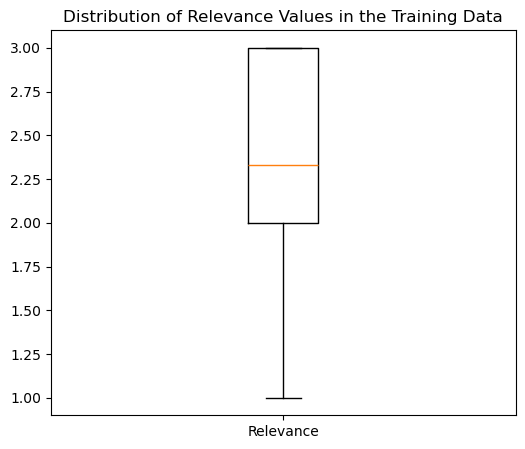

value
Unbranded                     2954
Hampton Bay                   1723
KOHLER                        1389
Everbilt                      1381
Home Decorators Collection    1275
GE                             987
Prime-Line                     931
Crown Bolt                     878
Delta                          853
DEWALT                         675
Name: count, dtype: int64

In [7]:
# total number of data-query pairs in training data:
train_df.info()

# number of unique products in training data:
print(train_df['product_uid'].nunique())

# two most occuring products in training data:
most_occuring = train_df['product_uid'].value_counts().iloc[:2]
for product_uid, count in most_occuring.items():
    name = train_df[train_df['product_uid'] == product_uid]['product_title'].values[0]
    print(f"Product UID: {product_uid}, Count: {count}, Name: {name}")

# Descriptive statistics for the relevance values (mean, median, standard deviation) in training data
print(train_df['relevance'].describe())

# histogram of relevance values in training data
plt.figure(figsize=(6, 5))
plt.boxplot(train_df['relevance'], tick_labels=['Relevance'])
plt.title("Distribution of Relevance Values in the Training Data")
plt.show()

# most frequent brand names in attributes data
brands = attributes_df[attributes_df['name'] == 'MFG Brand Name']
brands_count = brands['value'].value_counts().head(10)
display(brands_count)

## Baseline method:

Still need to adapt the code to work for this...

In [8]:
stemmer = SnowballStemmer('english')

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()]) # stems all words in a string

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split()) # counts number of words in str1 that are in str2


In [80]:
def get_df_all():
    # read in data
    df_train = pd.read_csv('data/train.csv', encoding="ISO-8859-1")
    df_test = pd.read_csv('data/test.csv', encoding="ISO-8859-1")
    df_pro_desc = pd.read_csv('data/product_descriptions.csv')
    df_attr = pd.read_csv('data/attributes.csv')

    num_train = df_train.shape[0]

    # combine train and test data, and merge with product descriptions
    df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
    df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
    return df_all, num_train

df_all, num_train = get_df_all()

In [10]:
def data_preprocessing(df_all, stemming=True):
    """
    Preprocesses the data by applying stemming and generating features based on the search term and product information.
    Skips stemming if stemming is set to False.
    """ 

    # create copy for keeping original data intact
    df_all = df_all.copy()

    # apply stemming
    if stemming:
        df_all['search_term'] = df_all['search_term'].apply(str_stemmer)
        df_all['product_title'] = df_all['product_title'].apply(str_stemmer)
        df_all['product_description'] = df_all['product_description'].apply(str_stemmer)

    # compute length of search terms
    df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
    # combine all product information into one column
    df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

    # count common words between search term and product title and description
    df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
    df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

    # clean up unnecessary columns
    df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

    # split train and test data again
    df_train = df_all.iloc[:num_train]
    df_test = df_all.iloc[num_train:]
    id_test = df_test['id']

    # split into x and y 
    y_train = df_train['relevance'].values
    X_train = df_train.drop(['id','relevance'],axis=1).values
    X_test = df_test.drop(['id','relevance'],axis=1).values

    return X_train, y_train, X_test, id_test

In [81]:
X_train, y_train, X_test, id_test = data_preprocessing(df_all)

In [12]:
def train_and_evaluate_model(X_train, y_train):
    # train test split on the TRAINING data, since test is unlabeled
    X_split_train, X_split_test, y_split_train, y_split_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    # train and test model
    rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
    clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
    clf.fit(X_split_train, y_split_train)

    # evaluate model performance
    y_pred = clf.predict(X_split_test)
    rmse = root_mean_squared_error(y_split_test, y_pred)
    print(f"RMSE: {round(rmse, 4)}")

train_and_evaluate_model(X_train, y_train)

RMSE: 0.4798


Testing the models without any stemming on the data:

In [13]:
X_train_stemless, y_train_stemless, X_test_stemless, id_test_stemless = data_preprocessing(df_all, stemming=False)
train_and_evaluate_model(X_train_stemless, y_train_stemless)

RMSE: 0.5111


## additional feature engineering
Things I want to try:
- 'brand_name_overlap' feature, whether the query mentions the brandname of the product.
- 'bullets_overlap' feature, counting how many words from the query are in the combined bulletpoints from the attributes.csv file. 
- Use TfIdfVectorizer to do the word overlap counting, instead of the sum.

In [70]:
df_all, _ = get_df_all()
df_attr = pd.read_csv('data/attributes.csv')

# get brand name from attributes data
brand_names = df_attr[df_attr['name'] == 'MFG Brand Name'].loc[:, ['product_uid', 'value']]
df_all = df_all.merge(brand_names, how='left', left_on='product_uid', right_on='product_uid')

# extract bullet point from data
bullet_df = df_attr[df_attr['name'].str.contains("Bullet", case=False, na=False)]

# group bullet points by product_uid and concatenate them
bullet_df_grouped = bullet_df.groupby('product_uid')['value'].apply(lambda x: ' '.join(str(v) for v in x if isinstance(v, str))).reset_index()
bullet_df_grouped.columns = ['product_uid', 'bullet_points']

# merge bullet point text with df_all
df_all = df_all.merge(bullet_df_grouped, how='left', on='product_uid')

In [71]:
# get all numerical attributes from df_attr
numerical_attributes_names = ['depth', 'height', 'length', 'width', 'weight', 'size']
numerical_attributes_dfs = []
for attr in numerical_attributes_names:
    numerical_attributes_df = df_attr[df_attr['name'].map(lambda x: str(x).lower()).str.contains(attr)].groupby('product_uid').agg(lambda x: ' '.join(str(v) for v in x if isinstance(v, str))).reset_index()
    numerical_attributes_dfs.append(numerical_attributes_df)

# concat all numerical attributes dataframes
numerical_attributes_df = pd.concat(numerical_attributes_dfs, axis=0).groupby('product_uid').agg(lambda x: ' '.join(str(v) for v in x if isinstance(v, str))).reset_index()
numerical_attributes_df.columns = ['product_uid', 'numerical_attributes_names', 'numerical_attributes']

# merge numerical attributes with df_all
df_all = df_all.merge(numerical_attributes_df, how='left', on='product_uid')
display(df_all.head())

,id,product_uid,product_title,search_term,relevance,product_description,value,bullet_points,numerical_attributes_names,numerical_attributes
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90° connection...,Product Depth (in.) Product Height (in.) Produ...,1.5 3 3 0.26
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90° connection...,Product Depth (in.) Product Height (in.) Produ...,1.5 3 3 0.26
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,"Revives wood and composite decks, railings, po...",Assembled Depth (in.) Assembled Height (in.) A...,6.63 in 7.76 in 6.63 in 1 GA-Gallon
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,"Includes the trim kit only, the rough-in kit (...",Product Depth (in.) Product Height (in.) Produ...,15.28 24 7.09 1/2 In.
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta,"Includes the trim kit only, the rough-in kit (...",Product Depth (in.) Product Height (in.) Produ...,15.28 24 7.09 1/2 In.


In [73]:
# apply stemming
df_all[['search_term', 'product_title', 'product_description']] = df_all[['search_term', 'product_title', 'product_description']].map(str_stemmer)
df_all['brand_name'] = df_all['value'].map(lambda x: str_stemmer(x) if isinstance(x, str) else x)
df_all['bullet_points'] = df_all['bullet_points'].map(lambda x: str_stemmer(x) if isinstance(x, str) else "")
df_all['numerical_attributes'] = df_all['numerical_attributes'].map(lambda x: str_stemmer(x) if isinstance(x, str) else "")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rapidfuzz import fuzz

vectorizer = TfidfVectorizer()

def tfidf_similarity(str1, str2):
    tfidf_matrix = vectorizer.fit_transform([str1, str2])
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    
    return similarity[0][0]

def fuzzy_similarity(str1, str2):
    return fuzz.partial_ratio(str1, str2)


# combine all product information into one column
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']+"\t"+df_all['brand_name']

# count common words between search term and product title and description
df_all['word_in_title'] = df_all['product_info'].map(lambda x:fuzzy_similarity(x.split('\t')[0], x.split('\t')[1]) if type(x) == str else 0)
df_all['word_in_description'] = df_all['product_info'].map(lambda x:fuzzy_similarity(x.split('\t')[0], x.split('\t')[2]) if type(x) == str else 0)
df_all['brand_in_query'] = df_all['product_info'].map(lambda x: fuzzy_similarity(x.split('\t')[0], x.split('\t')[3]) if type(x) == str else 0)
df_all['len_of_bullets'] = df_all['bullet_points'].map(lambda x: len(x.split()) if type(x) == str else 0)
df_all['query_in_bullets'] = df_all.apply(lambda x: fuzzy_similarity(x['search_term'], x['bullet_points']), axis=1)
# compute length of search terms
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['numerical_overlap'] = df_all.apply(lambda x: fuzzy_similarity(x['search_term'], x['numerical_attributes']), axis=1)


# clean up unnecessary columns
df_all_removed = df_all.drop(['search_term','product_title','product_description','product_info', 'brand_name', 'value', 'bullet_points', 'numerical_attributes', 'numerical_attributes_names'],axis=1)

# split train and test data again
df_train = df_all_removed.iloc[:num_train]
df_test = df_all_removed.iloc[num_train:]
id_test = df_test['id']

# split into x and y 
y_train_new_features = df_train['relevance'].values
X_train_new_features = df_train.drop(['id','relevance'],axis=1).values
X_test_new_features = df_test.drop(['id','relevance'],axis=1).values

In [75]:
# evaluate after adding the feature
train_and_evaluate_model(X_train_new_features, y_train_new_features)

RMSE: 0.4924


## comparison with other models
Task: Find three other regression models in the sklearn documentation and compare these for the task, 
both in quality (RMSE) and processing time

We can do: 
- Stochastic gradient descent https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
- SVM regressor https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
- MLP regressor https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

In [18]:
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time

# Stochastic gradient descent regression
def train_and_evaluate_regression(X_train, y_train, model):
    # train test split on the TRAINING data, since test is unlabeled
    X_split_train, X_split_test, y_split_train, y_split_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    start_time = time.time()
    # train and test model
    reg = make_pipeline(StandardScaler(), model)
    reg.fit(X_split_train, y_split_train)
    end_time = time.time()

    # evaluate model performance
    y_pred = reg.predict(X_split_test)
    rmse = root_mean_squared_error(y_split_test, y_pred)
    print(f"RMSE: {round(rmse, 4)}")
    print(f"Time taken: {round(end_time - start_time, 4)} seconds")

sgd = SGDRegressor(max_iter=2000, random_state=0)
svm = SVR(kernel='linear', C=1.0, epsilon=0.2)
mlp = MLPRegressor(max_iter=2000, tol=0.1, random_state=0)

# use X_train and y_train from the previous model
print("SGD Regressor:")
train_and_evaluate_regression(X_train, y_train, sgd)
print("SVM Regressor:")
train_and_evaluate_regression(X_train, y_train, svm)
print("MLP Regressor:")
train_and_evaluate_regression(X_train, y_train, mlp)

SGD Regressor:
RMSE: 0.4881
Time taken: 0.0172 seconds
SVM Regressor:
RMSE: 0.4937
Time taken: 46.0623 seconds
MLP Regressor:
RMSE: 0.4802
Time taken: 0.5473 seconds


## Hyperparameter optimization for MLP

In [ ]:
# grid search for hyperparameter tuning of MLP 
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.1,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [92]:
from sklearn.model_selection import GridSearchCV

# we optimize: alpha, epsilon, hidden_layer_sizes, learning_rate_init, max_fun, max_iter, momentum, n_iter_no_change, power_t, tol
parameters = {
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [0.1, 0.2, 0.3],
    'hidden_layer_sizes': [(100,), (150,), (200,), (250,), (300,)],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'tol': [0.0001, 0.001, 0.1],
}

clf = GridSearchCV(estimator=mlp, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=True, n_jobs=-1)
clf_fit = clf.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


In [93]:
print(clf_fit.best_params_)
print(clf_fit.best_score_)
print(clf_fit.best_estimator_)

optimized_mlp = clf_fit.best_estimator_
train_and_evaluate_regression(X_train, y_train, optimized_mlp)

{'alpha': 0.001, 'epsilon': 0.2, 'hidden_layer_sizes': (250,), 'learning_rate_init': 0.01, 'tol': 0.0001}
-0.7222185778415181
MLPRegressor(alpha=0.001, epsilon=0.2, hidden_layer_sizes=(250,),
             learning_rate_init=0.01, max_iter=2000, random_state=0)
RMSE: 0.4788
Time taken: 2.678 seconds


## Inspecting feature importances
On the random forest weeeeeeee

In [97]:
X_split_train, X_split_test, y_split_train, y_split_test = train_test_split(X_train_new_features, y_train_new_features, test_size=0.2, random_state=0)
rf_alone = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)

# get feature importances
rf_alone.fit(X_split_train, y_split_train)
importances = rf_alone.feature_importances_

# get feature names
feature_names = df_train.drop(['id', 'relevance'], axis=1).columns
# sort feature importances
indices = np.argsort(importances)[::-1]
# print feature ranking
print("Feature ranking:")
for f in range(X_split_train.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature word_in_title (0.3381227717783294)
2. feature product_uid (0.21527219802100375)
3. feature word_in_description (0.17216256677233988)
4. feature len_of_query (0.11726790500262663)
5. feature length_of_bullets (0.11509274191937509)
6. feature brand_in_query (0.028037672268782798)
7. feature word_in_bullets (0.008780880186372225)
8. feature numerical_overlap (0.005263264051170368)


In [ ]:
X_split_train, X_split_test, y_split_train, y_split_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
rf_alone = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)

# get feature importances
rf_alone.fit(X_split_train, y_split_train)
importances = rf_alone.feature_importances_

# get feature names
feature_names = df_train.drop(['id', 'relevance'], axis=1).columns
# sort feature importances
indices = np.argsort(importances)[::-1]
# print feature ranking
print("Feature ranking:")
for f in range(X_split_train.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature word_in_description (0.45937015950003285)
2. feature word_in_title (0.2756527467100413)
3. feature product_uid (0.2233430335601273)
4. feature brand_in_query (0.04163406022979853)


In [100]:
display(df_all)

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...
240755,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,NaN,Create a neat yet stylish storage space for or...
240756,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,NaN,Our Bullnose Adirondack Chair Cushions fit Adi...
240757,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,NaN,Joist hangers are designed to provide support ...
240758,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,NaN,These socket cap screws are ideal for applicat...
